In [1]:
# General import
import numpy as np
import os
from PIL import Image
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
# Local import
from Codes.dataprocess import DataLoader
from Codes.dataprocess import Blurr
from Codes.dataprocess import Add_noise
from Codes.algoviolet import violetBD
from Codes.display import Display_ker
from Codes.display import Display_im
from Codes.display import Display_epd
from Codes.myfunc import nablah
from Codes.myfunc import convolve

# Minimisation fonction bi-convexe concave

On introduit le probleme d'optimisation biconvex-concave
de déconvolution aveugle d'images 
avec l' a priori de noyau de convolution régulier,

$$
\underset{u \in U ,K \in \Sigma}{\text{min}} \; \underset{v}{\text{sup}} \;
\frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \langle \nabla u , v \rangle
+ \chi_{B,\mu}(v)
\; .
$$

L'espace $\Sigma$ correspond à l'ensemble des simplexes 
(ensemble des noyaux à coefficient positif dont la somme des coefficients vaut 1).
Par extension on notera $\Sigma$ la fonction indicatrice de cet ensemble.
L'espace $U$ correspond à l'hypercube $[0,1]^{N_x \times N_y}$, ou la boule unité pour la norme $L^\infty$.
Sa fonction indicatrice correspond donc à $\chi_{B,1}$.

La fonction à minimiser peut alors se réécrire

$$
\underset{u ,K }{\text{min}} \; \underset{v}{\text{sup}} \;
\frac{1}{2} \| g - K * u\|^2 
+ \chi_{B,1} (u)
+ \frac{1}{2} \alpha \| D K \|^2
+ \Sigma(K)
+\langle \nabla u , v \rangle
+ \chi_{B,\mu}(v)
\; .
$$

On note

$$
L =\frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \mu \langle \nabla u , v \rangle
$$

Pour résoudre ce probleme d'optimisation on se propose de tester l'algorithme suivant,

$$
\left\{
\begin{align}
& \tilde{u}_{k+1} = \text{proj}_{B_1} \; (u_k - \tau \partial_u L(u_k,K_k,v_k) \; )\\
& K_{k+1} = \text{prox}_{\Sigma} \; (K_k - \gamma \partial_K L(\tilde{u}_{k+1},K_k,v_k) \; )\\
& v_{k+1}         = \text{prox}_{B_\mu} \; (v_k + \sigma \partial_v L (u_{k+1},K_{k+1},v_k) \; )\\
& u_{k+1} = \tilde{u}_{k+1} + \theta_u (\tilde{u}_{k+1} - u_k) \quad \text{(relaxation)}
\end{align}
\right.
$$

\underline{Question} :
est-ce qu'on met une relaxation aussi sur $K$ ?

$$
K_{k+1} = \tilde{K}_{k+1} + \theta_K (\tilde{K}_{k+1} - K_k)  \quad \text{(relaxation aussi ?)}
$$

On écrit alors les dérivées partielles de $L$,

$$
\left\{
\begin{align}
& \partial_u L(u_k,K_k,v_k) \; ) = \text{div} \cdot v_k - \tilde{K} * (g-K*u)\\
& \partial_K L(\tilde{u}_{k+1},K_k,v_k) \; ) = - (g-K*u)*\tilde{u} + \alpha D^TDK \\
& \partial_v L (u_{k+1},K_{k+1},v_k) \; ) =  \nabla u
\end{align}
\right.
$$

On trace les énergies primales et duales au cours de la minimisation

$$
\left\{
\begin{align}
& Ep = \frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \mu. \text{TV} (u) \\
\\
& Ed = - \langle \nabla u ,v \rangle - \chi_{B,\mu}(v)
\end{align}
\right.
$$

In [2]:
file_name = 'Images'
im_name   = 'image01.png'
x_i = DataLoader(file_name,im_name)
x_i = x_i/np.amax(x_i)# Rescaling

In [3]:
M             = 20
gridx, gridy  = np.meshgrid(np.linspace(-1,1,2*M), np.linspace(-1,1,2*M))
gd            = np.sqrt(gridx*gridx+gridy*gridy)
sigma,moy     = 0.2, 0.0
K             = np.exp(-( (gd-moy)**2 / ( 2.0 * sigma**2 ) ) )
K             = K/K.sum() # Simplex

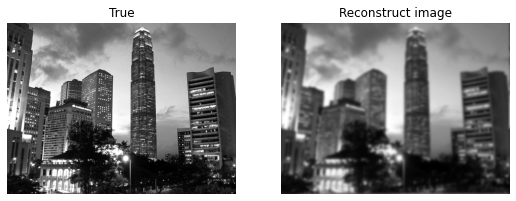

Erreur |x_pred - x_true|_2 : 0.22740947882930476


In [4]:
x_b  = Blurr(x_i,K)
x_o1 = Add_noise(x_b,noise_level=0.05)
Display_im(x_o1,x_i,mysize=(9,5))

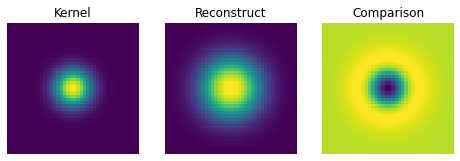

Erreur |K_pred - K_true|_2 : 0.5253166535672434


In [5]:
sigma,moy  = 0.3, 0.05
K_shift    = np.exp(-( (gd-moy)**2 / ( 2.0 * sigma**2 ) ) )
K_shift    = K_shift/K_shift.sum() # Simplex
Display_ker(K_shift,K,mysize=(8,4))

In [6]:
Nx,Ny = x_i.shape
# Kernel padding
K_pad = np.zeros(x_i.shape)
K_pad[Nx//2+1-M-2:Nx//2+M-1,Ny//2+1-M-2:Ny//2+M-1] = K
# Derivation padding
d      = -np.ones((3,3))
d[1,1] = 8
d_pad  = np.zeros((Nx,Ny))
d_pad[Nx//2-1:Nx//2+2,Ny//2-1:Ny//2+2] = d
# Parameters
alpha = 5
mu    = 0
#
conv1 = convolve(K_pad,x_i)
conv2 = convolve(d_pad,K_pad)
ux,uy = nablah(x_i)
normu = np.abs(ux)+np.abs(uy)
#
Ep_b  = 0.5*np.linalg.norm(conv1-x_b)**2 \
          + 0.5*alpha*(2*M)**2*np.linalg.norm(conv2)**2\
          + mu/Nx/Ny*np.sum(normu)
Ep_o1  = 0.5*np.linalg.norm(conv1-x_o1)**2 \
          + 0.5*alpha*(2*M)**2*np.linalg.norm(conv2)**2\
          + mu/Nx/Ny*np.sum(normu)
print(Ep_b,Ep_o1)

1.5631699190582675 1.5633361971740107


## Initialisation du noyau exacte - bruit 1%

In [7]:
alpha = 1.0
mu    = 0.5
K_in   = K.copy()
x_in  = x_o1
K_out,x_out,Ep,Ed = violetBD(K_in,x_in,x_b,\
                            alpha,mu,theta=1,\
                            niter=200,\
                            proj_simplex=False)

stops prematurely at 189 iterations : the primal energy rises


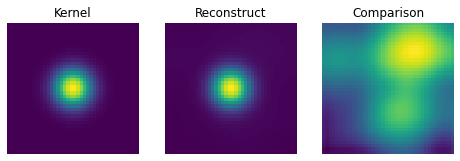

Erreur |K_pred - K_true|_2 : 0.032932799955018


In [8]:
Display_ker(K_out,K,mysize=(8,4))

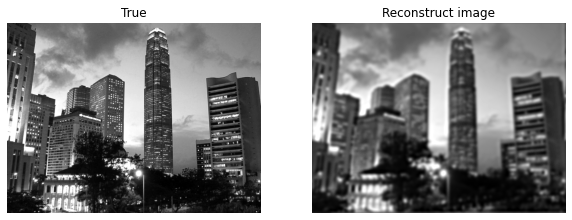

Erreur |x_pred - x_true|_2 : 0.21661801150081283


In [9]:
Display_im(x_out,x_i,mysize=(10,5))

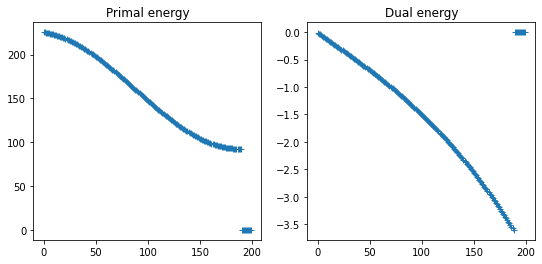

In [10]:
Display_epd(Ep,Ed)

## Initialisation noyau proche - pas de bruit

In [11]:
alpha     = 0.01
mu        = 0.5
sigma,moy = 0.15, 0.05
K_in      = K_shift.copy()
x_in      = x_b
K_out,x_out,Ep,Ed = violetBD(K_in,x_in,x_b,\
                            alpha,mu,theta=1,\
                            niter=200,\
                            proj_simplex=False)

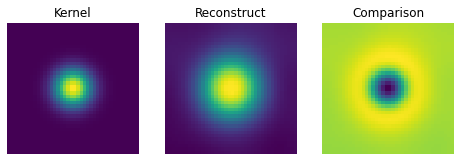

Erreur |K_pred - K_true|_2 : 0.5221815407152314


In [12]:
Display_ker(K_out,K,mysize=(8,4))

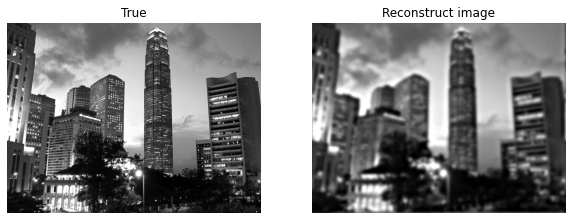

Erreur |x_pred - x_true|_2 : 0.22479407806040305


In [13]:
Display_im(x_out,x_i,mysize=(10,5))

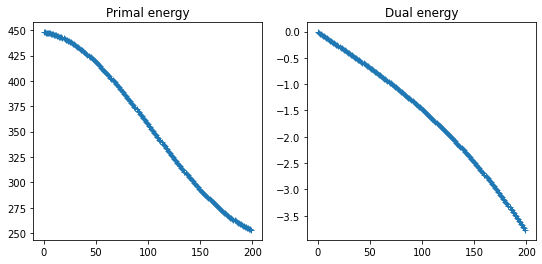

In [14]:
Display_epd(Ep,Ed)

## Initialisation noyau proche - bruit 1%

In [15]:
alpha = 1.0
mu    = 0.5
sigma,moy = 0.15, 0.05
K_in      = K_shift.copy()
x_in      = x_b
K_out,x_out,Ep,Ed = violetBD(K_in,x_in,x_o1,\
                            alpha,mu,theta=1,\
                            niter=200,\
                            proj_simplex=False)

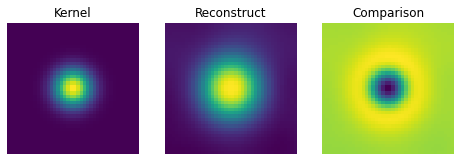

Erreur |K_pred - K_true|_2 : 0.522197399119307


In [16]:
Display_ker(K_out,K,mysize=(8,4))

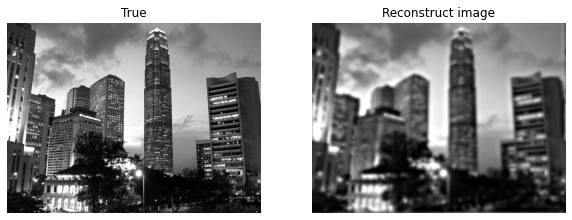

Erreur |x_pred - x_true|_2 : 0.22479373101036623


In [17]:
Display_im(x_out,x_i,mysize=(10,5))

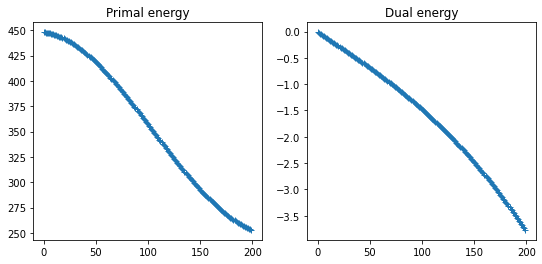

In [18]:
Display_epd(Ep,Ed)